<a href="https://colab.research.google.com/github/FrenitaFernandes/eye_disease_project/blob/main/eye%20disease%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# 1. Import necessary libraries
import tensorflow as tf
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

In [20]:
# 2. Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounted at /content/drive


In [21]:
# 3. Extract ZIP file
zip_path = '/content/drive/MyDrive/Frenita (1)/eyeimage.zip'
extract_path = '/content/eyeimage'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete.")

Extraction complete.


In [22]:
# 4. Remove extra 'eyeimage' folder if it exists inside /content/eyeimage/eyeimage
extra_folder = '/content/eyeimage/eyeimage/eyeimage'
if os.path.exists(extra_folder):
    import shutil
    shutil.rmtree(extra_folder)
    print("Removed extra 'eyeimage' folder.")

Removed extra 'eyeimage' folder.


In [23]:
# 5. Clean non-image files (optional, but safe)
def clean_image_folder(folder):
    removed = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1
    print(f"Removed {removed} non-image files.")

clean_image_folder('/content/eyeimage/eyeimage')


Removed 0 non-image files.


In [27]:

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/eyeimage/eyeimage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # use your variable here
    batch_size=BATCH_SIZE,                # and here
    label_mode='int'
)


Found 4217 files belonging to 4 classes.


In [28]:
# 7. Check class names and number of files
class_names = dataset.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [30]:
len(dataset)

132

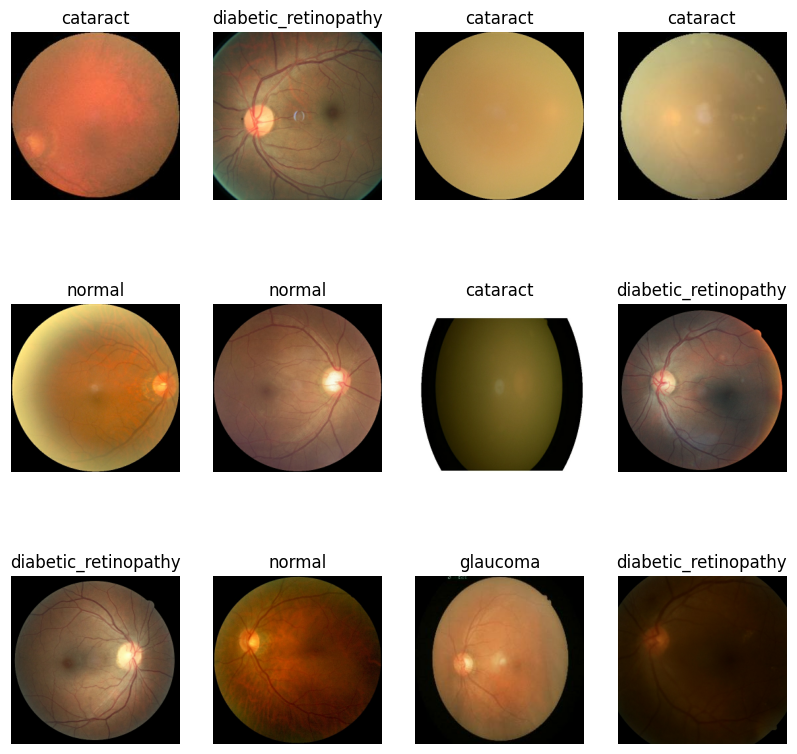

In [32]:
# Visualize a batch before normalization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
plt.show()

In [34]:
# Add normalization as a preprocessing layer in your model
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

Original min/max: 0.0 255.0
Rescaled min/max: 0.0 1.0


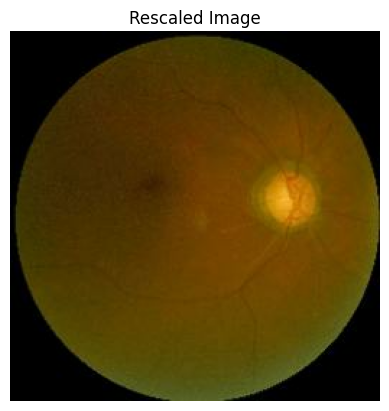

In [35]:
#Visualization after normalizing
# Take a batch from your dataset
for image_batch, label_batch in dataset.take(1):
    # Pass the batch through the resize_and_rescale layer
    rescaled_images = resize_and_rescale(image_batch)
    print("Original min/max:", image_batch.numpy().min(), image_batch.numpy().max())
    print("Rescaled min/max:", rescaled_images.numpy().min(), rescaled_images.numpy().max())

    # Visualize a rescaled image (values will be between 0 and 1)
    import matplotlib.pyplot as plt
    plt.imshow(rescaled_images[0].numpy())
    plt.title("Rescaled Image")
    plt.axis("off")
    plt.show()
    break

In [37]:
!pip install split-folders

In [38]:
import splitfolders

# Set your input and output folder paths
input_folder = "/content/eyeimage/eyeimage"      # Folder with your class subfolders
output_folder = "/content/eyeimage_split"        # New folder to store split data

# Split with 80% training, 10% validation, 10% testing
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(.8, .1, .1),    # 80% train, 10% val, 10% test
    group_prefix=None
)

Copying files: 4217 files [00:13, 314.78 files/s]


In [40]:

#Visualizing train images,test images and validate images
import os

def count_images(folder):
    total = 0
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

base_path = "/content/eyeimage_split"
for split in ["train", "val", "test"]:
    split_path = os.path.join(base_path, split)
    print(f"{split.capitalize()} images:", count_images(split_path))

Train images: 3372
Val images: 419
Test images: 426


In [41]:
# Load each split from its folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/eyeimage_split/train",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/eyeimage_split/val",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/eyeimage_split/test",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# To check the number of batches in each split
print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))
print("Test batches:", len(test_ds))

Found 3372 files belonging to 4 classes.
Found 419 files belonging to 4 classes.
Found 426 files belonging to 4 classes.
Train batches: 106
Validation batches: 14
Test batches: 14


In [43]:
##5.Data Augmentation (optional but recommended)

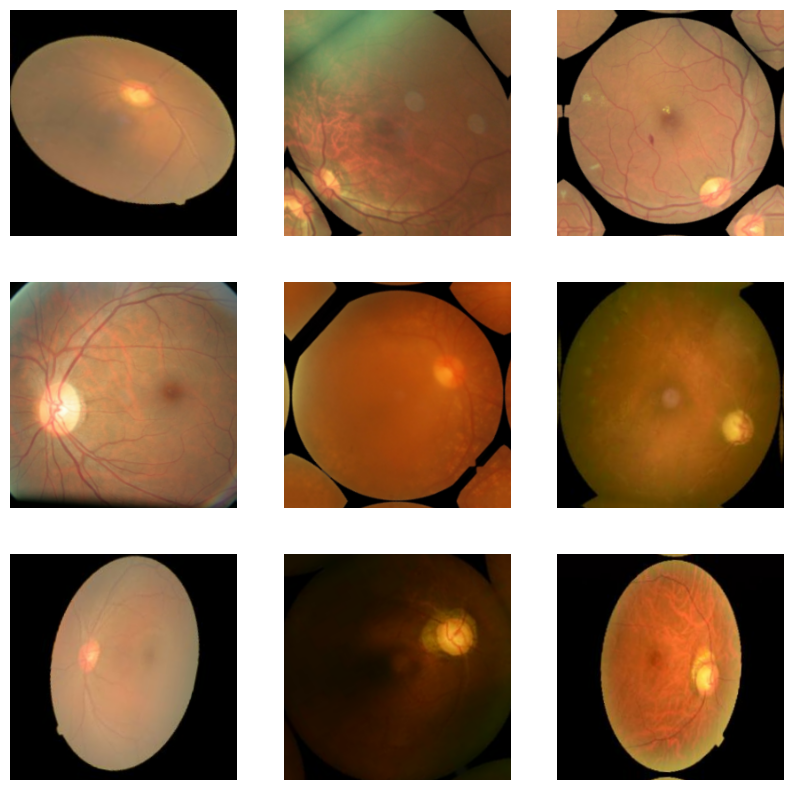

In [44]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# Example: Apply augmentation to a batch from train_ds and visualize
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()
    break

In [45]:
##6.Model training which is best for this dataset

In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models
def build_model(base_model):
    base_model.trainable = False  # Freeze the base model
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [47]:
mobilenet_base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
efficientnet_base = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
resnet_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

mobilenet_model = build_model(mobilenet_base)
efficientnet_model = build_model(efficientnet_base)
resnet_model = build_model(resnet_base)

/tmp/ipython-input-3031307392.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
##Train Each Model

EPOCHS = 15  # You can increase for better results

print("Training MobileNetV2...")
history_mobilenet = mobilenet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Then add callbacks=[early_stop] in model.fit(...)

print("Training EfficientNetB0...")
history_efficientnet = efficientnet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Then add callbacks=[early_stop] in model.fit(...)




#print("Training ResNet50...")
#history_resnet = resnet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Training MobileNetV2...
Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.6508 - loss: 0.8726 - val_accuracy: 0.8329 - val_loss: 0.4349
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8284 - loss: 0.4626 - val_accuracy: 0.8878 - val_loss: 0.3373
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8595 - loss: 0.3722 - val_accuracy: 0.8735 - val_loss: 0.3332
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8828 - loss: 0.3387 - val_accuracy: 0.8998 - val_loss: 0.2901
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.8877 - loss: 0.3054 - val_accuracy: 0.8878 - val_loss: 0.2928
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.8969 - loss: 0.2686 - val_accuracy: 0.9069 - val_loss: 0.2583
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9007 - loss: 0.2600 - val_accuracy: 0.9069 - val_loss: 0.2528
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9146 -

KeyboardInterrupt: 